In [1]:
# import libraries
import numpy as np
import torch

import torch.nn as nn
import torch.nn.functional as F

# for importing data
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset

import copy
import matplotlib.pyplot as plt
from IPython import  display
display.set_matplotlib_formats('svg')


In [2]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
# transformations
transform = T.Compose([ T.ToTensor(),
                        T.RandomHorizontalFlip(p=.5),
                        T.Normalize(.5,.5),
                       ])

# import the data and simultaneously apply the transform
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,  download=True, transform=transform)
devtest  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# split the devtest into two separate sets
randidx = np.random.permutation(10000)   # a random permutation of indices
devset  = Subset(devtest,randidx[:6000]) # Subset for devset
testset = Subset(devtest,randidx[6000:]) # Subset for test

# transform to dataloaders
batchsize    = 32
train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
dev_loader   = DataLoader(devset,  batch_size=len(devset))
test_loader  = DataLoader(testset, batch_size=len(testset))

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



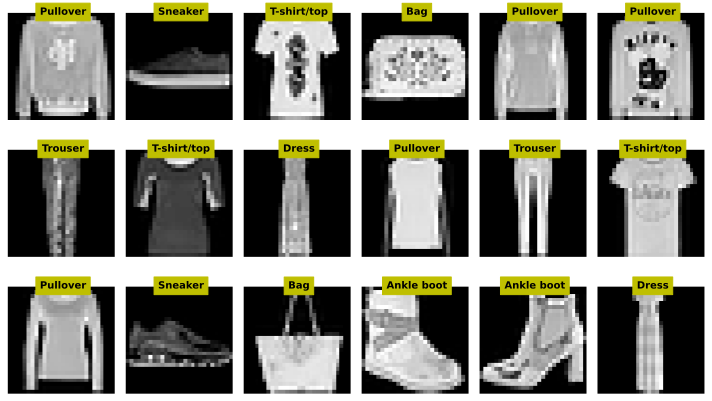

In [4]:
# inspect a few random images
X,y = next(iter(train_loader))
fig,axs = plt.subplots(3,6,figsize=(10,6))

for(i,ax) in enumerate (axs.flatten()):
    # extract that image
    pic = torch.squeeze(X.data[i])
    pic = pic/2 + .5

    # and its label
    label = trainset.classes[y[i]]

    # and show
    ax.imshow(pic,cmap='gray')

    ax.text(14,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Create the autoencoder model

In [5]:
# create a class for the model
def makeTheAENet(printtoggle=False):
    

  class aenet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()
      
      # print toggle
      self.print = printtoggle

      ### -------------- encoder layers -------------- ###
      # first convolution layer
      self.encconv1  = nn.Conv2d(1,16,3,padding=1,stride=2)
      # output size: (28+2*1-3)/2 + 1 = 14

      # second convolution layer
      self.encconv2  = nn.Conv2d(16,32,3,padding=1,stride=2)
      # output size: (14+2*1-3)/2 + 1 = 7
      

      ### -------------- decoder layers -------------- ###
      # first convolution layer
      self.decconv1  = nn.ConvTranspose2d(32,16,4,padding=1,stride=2)
      # output size: (28+2*1-3)/2 + 1 = 14

      # second convolution layer
      self.decconv2  = nn.ConvTranspose2d(16,1,4,padding=1,stride=2)
      # output size: (14+2*1-3)/2 + 1 = 7
      



    def forward(self,x):
      
      if self.print: print(f'Input: {list(x.shape)}')
      
      # first encoder layer
      x = F.leaky_relu(self.encconv1(x))
      if self.print: print(f'First encoder layer: {list(x.shape)}')

      # second encoder layer
      x = F.leaky_relu(self.encconv2(x))
      if self.print: print(f'Second encoder layer: {list(x.shape)}')

      # first decoder layer
      x = F.leaky_relu(self.decconv1(x))
      if self.print: print(f'First decoder layer: {list(x.shape)}')

      # second decoder layer
      x = F.leaky_relu(self.decconv2(x))
      if self.print: print(f'Second decoder layer: {list(x.shape)}')

      return x

  # create the model instance
  net = aenet(printtoggle)
  
  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [6]:
# test the model with one batch
tmpnet,lossfun,optimizer = makeTheAENet(True)

X,y = iter(train_loader).next()
yHat = tmpnet(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,X)
print(' ')
print('Loss:')
print(loss)

Input: [32, 1, 28, 28]
First encoder layer: [32, 16, 14, 14]
Second encoder layer: [32, 32, 7, 7]
First decoder layer: [32, 16, 14, 14]
Second decoder layer: [32, 1, 28, 28]

Output size:
torch.Size([32, 1, 28, 28])
 
Loss:
tensor(0.6582, grad_fn=<MseLossBackward0>)


# Create a function that trains the autoencoder model

In [7]:
# a function that trains the model

def function2trainTheAEModel():

  # number of epochs
  numepochs = 10
  
  # create a new model
  net,lossfun,optimizer = makeTheAENet()

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  devLoss   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train() # switch to train mode
    batchLoss = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,X)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and accuracy from this batch
      batchLoss.append(loss.item())
    # end of batch loop...

    # and get average losses and accuracies across the batches
    trainLoss[epochi] = np.mean(batchLoss)


    #### test performance
    net.eval() # switch to test mode
    X,y = next(iter(dev_loader))

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    # forward pass and loss
    with torch.no_grad():
      yHat = net(X)
      loss = lossfun(yHat,X)

    # and get average losses and accuracies across the batches
    devLoss[epochi] = loss.item()

  # end epochs

  # function output
  return trainLoss,devLoss,net

In [8]:
trainLoss,devLoss,aenet = function2trainTheAEModel()

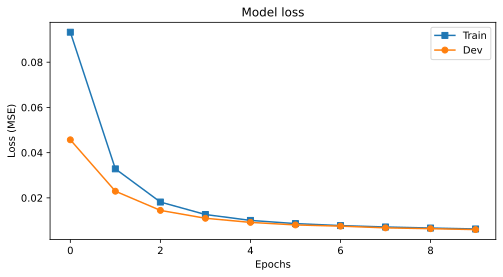

In [9]:
fig = plt.figure(figsize=(8,4))

plt.plot(trainLoss,'s-',label='Train')
plt.plot(devLoss,'o-',label='Dev')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model loss')
plt.legend()

plt.show()

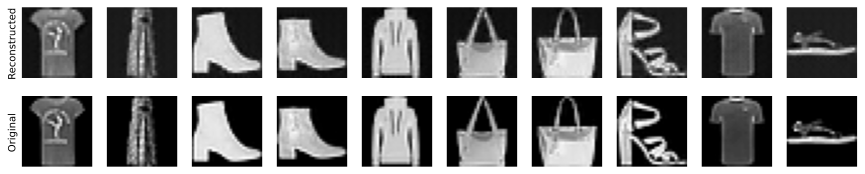

In [10]:
## show some random examples

# get some data
X,y = next(iter(dev_loader))

# forward pass and loss
aenet.cpu()
aenet.eval() # switch to test mode
yHat = aenet(X)

fig,axs = plt.subplots(2,10,figsize=(15,3))

for i in range(10):
  pic = yHat[i,0,:,:].detach()
  pic = pic/2 + .5 # undo normalization
  axs[0,i].imshow(pic,cmap='gray')
  axs[0,i].axis('off')

  pic = X[i,0,:,:].detach()
  pic = pic/2 + .5 # undo normalization
  axs[1,i].imshow(pic,cmap='gray')
  axs[1,i].axis('off')

  if i==0:
    axs[0,0].text(-6,14,'Reconstructed',rotation=90,va='center')
    axs[1,0].text(-6,14,'Original',rotation=90,va='center')

  
plt.show()

# Now create a new model that does classification

In [11]:
# create a class for the model
def makeTheClassNet(printtoggle=False):

  class cnnnet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()
      
      # print toggle
      self.print = printtoggle

      ### -------------- encoder layers -------------- ###
      # first convolution layer
      self.encconv1  = nn.Conv2d(1,16,3,padding=1,stride=2)
      # output size: (28+2*1-3)/2 + 1 = 14

      # second convolution layer
      self.encconv2  = nn.Conv2d(16,32,3,padding=1,stride=2)
      # output size: (14+2*1-3)/2 + 1 = 7
      

      ### ------------- linear layers ------------- ###
      self.fc1  = nn.Linear(7*7*32,50)
      self.fc2  = nn.Linear(50,10)
      

    def forward(self,x):
      
      if self.print: print(f'Input: {list(x.shape)}')
      
      # first encoder layer
      x = F.leaky_relu(self.encconv1(x))
      if self.print: print(f'First encoder layer: {list(x.shape)}')

      # second encoder layer
      x = F.leaky_relu(self.encconv2(x))
      if self.print: print(f'Second encoder layer: {list(x.shape)}')

      # reshape to linear
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Post-convolution vectorized: {list(x.shape)}')

      # linear layers
      x = F.leaky_relu(self.fc1(x))
      if self.print: print(f'First linear layer: {list(x.shape)}')

      x = F.leaky_relu(self.fc2(x))
      if self.print: print(f'Second linear layer: {list(x.shape)}')

      return x

  # create the model instance
  net = cnnnet(printtoggle)
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [12]:
# test the model with one batch
tmpnet,lossfun,optimizer = makeTheClassNet(True)

X,y = iter(train_loader).next()
yHat = tmpnet(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

Input: [32, 1, 28, 28]
First encoder layer: [32, 16, 14, 14]
Second encoder layer: [32, 32, 7, 7]
Post-convolution vectorized: [32, 1568]
First linear layer: [32, 50]
Second linear layer: [32, 10]

Output size:
torch.Size([32, 10])
 
Loss:
tensor(2.2955, grad_fn=<NllLossBackward0>)
